In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

#machine learning imports
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.cluster import DBSCAN

#set visulaization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = [12,7]


In [27]:
#Load the data
try:
    df = pd.read_csv('telecom_kpi_data.csv', parse_dates=['timestamp'])
    print('Data loaded successfully')
except:
    print('CSV file not found, run the data_load notebook first')

Data loaded successfully


#### 1. Data Preprocessing

In [28]:
# select relevant kpi features
kpi_features = ['traffic_load_mbps', 'latency_ms', 'packet_loss_pct', 'conn_success_rate', 'signal_strength_dbm']

# Create a flag for known anomalies (to evaluate our models)
# As Anomaly defined, where at lease 2 kpis have anomalies
df['known_anomaly'] = df['anomaly_count'] >= 2

# Stnadardize the data
scaler = StandardScaler()
df_scaled = pd.DataFrame(
    scaler.fit_transform(df[kpi_features]),
    columns=kpi_features,
    index=df.index
)
print(f"\nTotal Samples:{len(df)}")
print(f"Known Anomalies: {df['known_anomaly'].sum()} ({df['known_anomaly'].sum()/len(df)*100:.2f}%)")




Total Samples:1344
Known Anomalies: 31 (2.31%)


#### 2. Model Implementation

In [29]:
# Function to plot anomaly detection results
def plot_anomaly_results(df, y_pred, model_name):
    # Crate a copy of the dataframe with the predictions
    results = df.copy()
    results[f'{model_name}_anomaly'] = y_pred
    
    #Create True positives false negatives etc..
    tp = ((results['known_anomaly']==1) & (results[f'{model_name}_anomaly']==-1)).sum()
    fp = ((results['known_anomaly']==0) & (results[f'{model_name}_anomaly']==-1)).sum()
    tn = ((results['known_anomaly']==0) & (results[f'{model_name}_anomaly']==1)).sum()
    fn = ((results['known_anomaly']==1) & (results[f'{model_name}_anomaly']==1)).sum()
    
    # Calculate precision, recall and f1-score
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    #Plot the results
    fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
    
    
    #Plot 1 traffic load with Anomalies
    axes[0].plot(results['timestamp'], results['traffic_load_mbps'],  label='Traffic Load', alpha=0.7)
    
    # Plot Known anomalies
    known_anomalies = results[results['known_anomaly']==1]
    axes[0].scatter(known_anomalies['timestamp'], known_anomalies['traffic_load_mbps'], color='red', label='Known Anomalies', marker='o', s=50 )
    
    #Plot detected anomalies
    detected_anomalies = results[results[f'{model_name}_anomaly']==-1]
    axes[0].scatter(detected_anomalies['timestamp'], detected_anomalies['traffic_load_mbps'], color='yellow', label='Detected Anomalies', marker='*', s=100, edgecolors='black')
    axes[0].set_title(f'Traffic Load with Anomalies ({model_name})')
    axes[0].legend()
    
    #Plot 2 Latecy with Anomalies
    axes[1].plot(results['timestamp'], results['latency_ms'],  label='Latency', alpha=0.7)
    
    # Plot Known anomalies
    axes[1].scatter(known_anomalies['timestamp'], known_anomalies['latency_ms'], color='red', label='Known Anomalies', marker='o', s=50 )
    
    #Plot detected anomalies
    axes[1].scatter(detected_anomalies['timestamp'], detected_anomalies['latency_ms'], color='yellow', label='Detected Anomalies', marker='*', s=100, edgecolors='black')
    axes[1].set_title(f'Latency with Anomalies ({model_name})')
    axes[1].legend()
    
    plt.tight_layout()
    plt.savefig(f'{model_name}_anomaly_detection.png')
    plt.show()
    
    #Print performance metrics
    print(f'{model_name} Performance Metrics')
    print(f'True Positives: {tp}')
    print(f'False Positives: {fp}') 
    print(f'True Negatives: {tn}')
    print(f'False Negatives: {fn}')
    print(f'Precision: {precision:.2f}')
    print(f'Recall: {recall:.2f}')
    print(f'F1-Score: {f1:.2f}')
    
    return results

##### 2.1.Isolation Forest


==== Isolation Forest ====


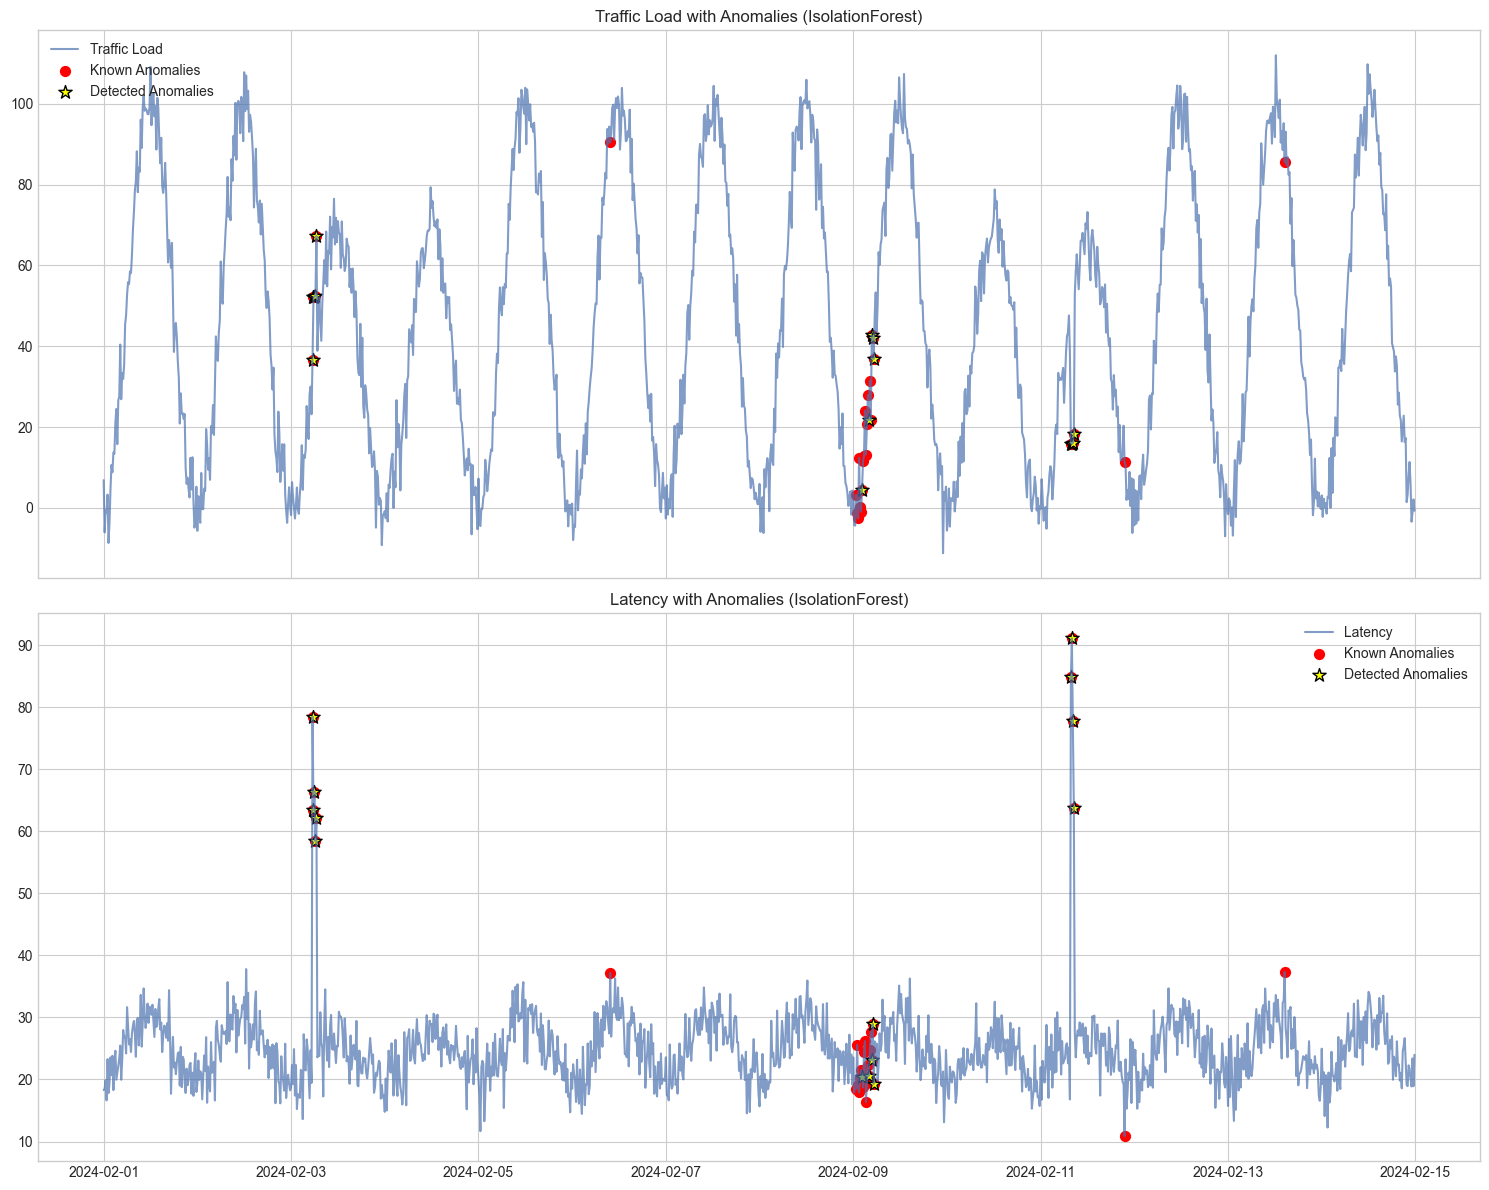

IsolationForest Performance Metrics
True Positives: 14
False Positives: 0
True Negatives: 1313
False Negatives: 17
Precision: 1.00
Recall: 0.45
F1-Score: 0.62


In [30]:
print("\n==== Isolation Forest ====")
# Train the Isolation Forest model
iso_forest = IsolationForest(
    n_estimators=100,
    contamination=0.01,
    random_state=42
    )
iso_forest_pred = iso_forest.fit_predict(df_scaled)
iso_results = plot_anomaly_results(df, iso_forest_pred, 'IsolationForest')

#### 2.2.OneClassSVM


==== One Class SVM ====


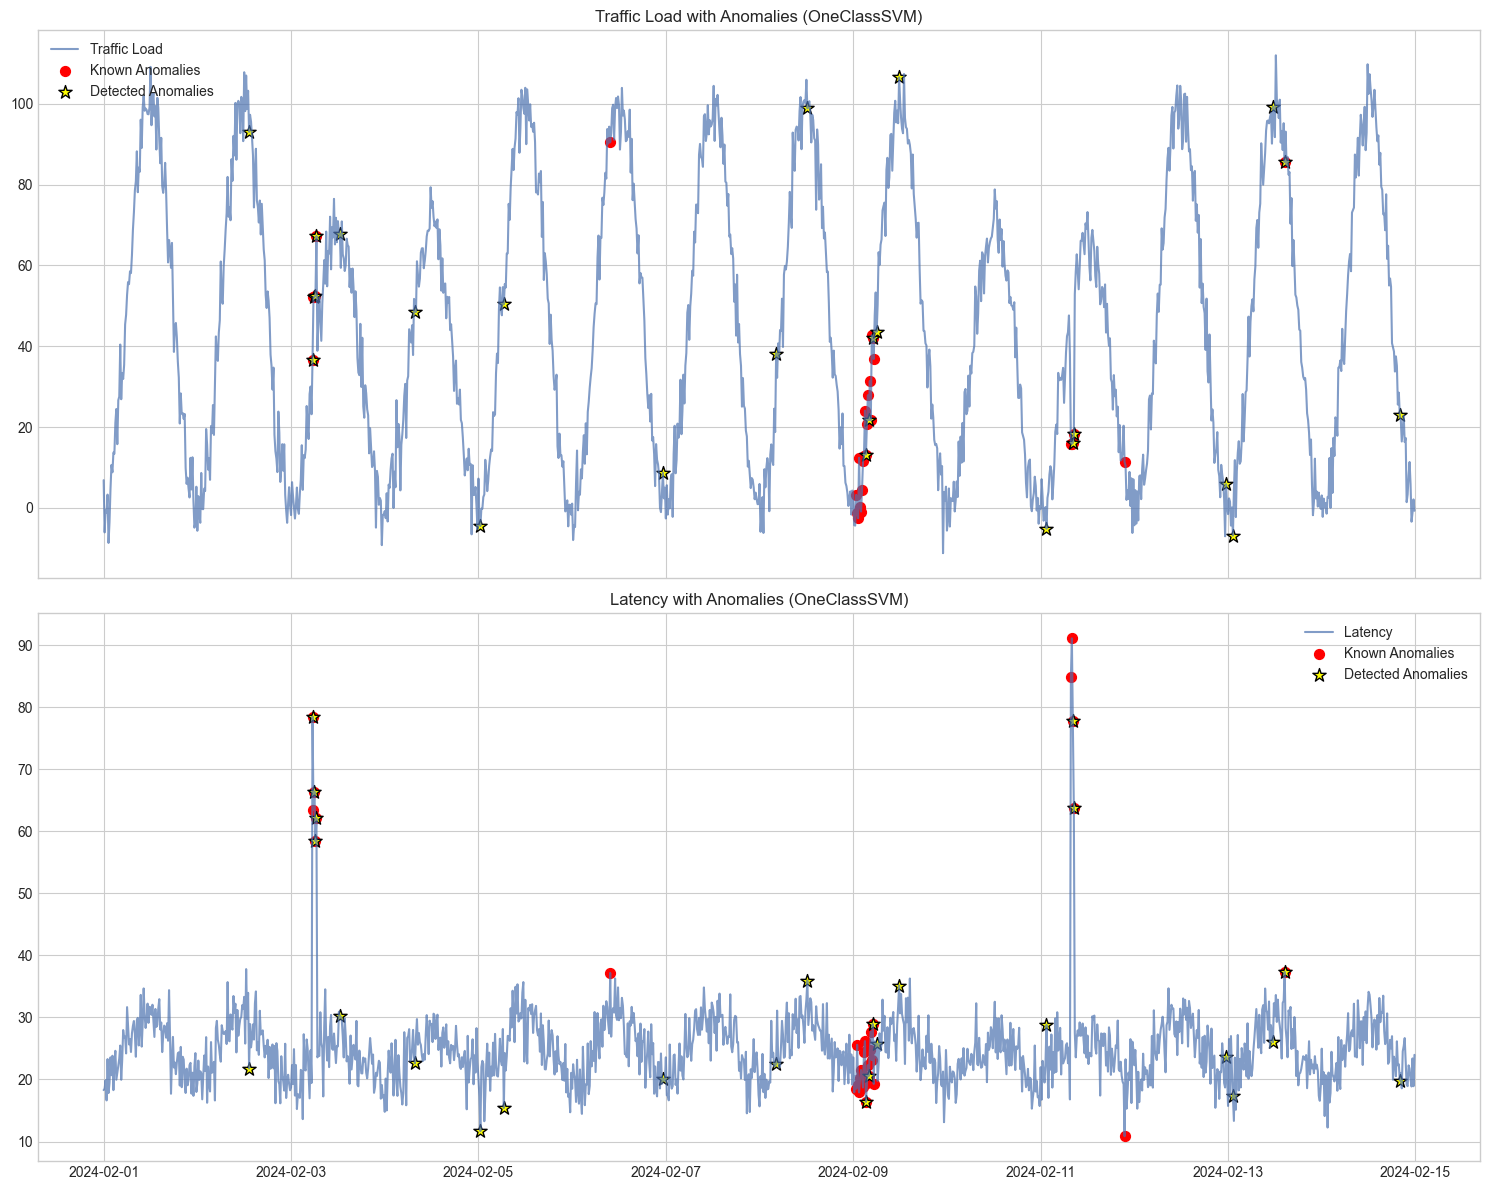

OneClassSVM Performance Metrics
True Positives: 10
False Positives: 15
True Negatives: 1298
False Negatives: 21
Precision: 0.40
Recall: 0.32
F1-Score: 0.36


In [31]:
print("\n==== One Class SVM ====")
# Train the One Class SVM model

one_class_svm = OneClassSVM(gamma='auto',nu=0.01)

#Fit and predict
one_class_svm_pred = one_class_svm.fit_predict(df_scaled)
one_class_svm_results = plot_anomaly_results(df, one_class_svm_pred, 'OneClassSVM')



#### 2.3.Local Outlier factor


==== Local Outlier Factor ====


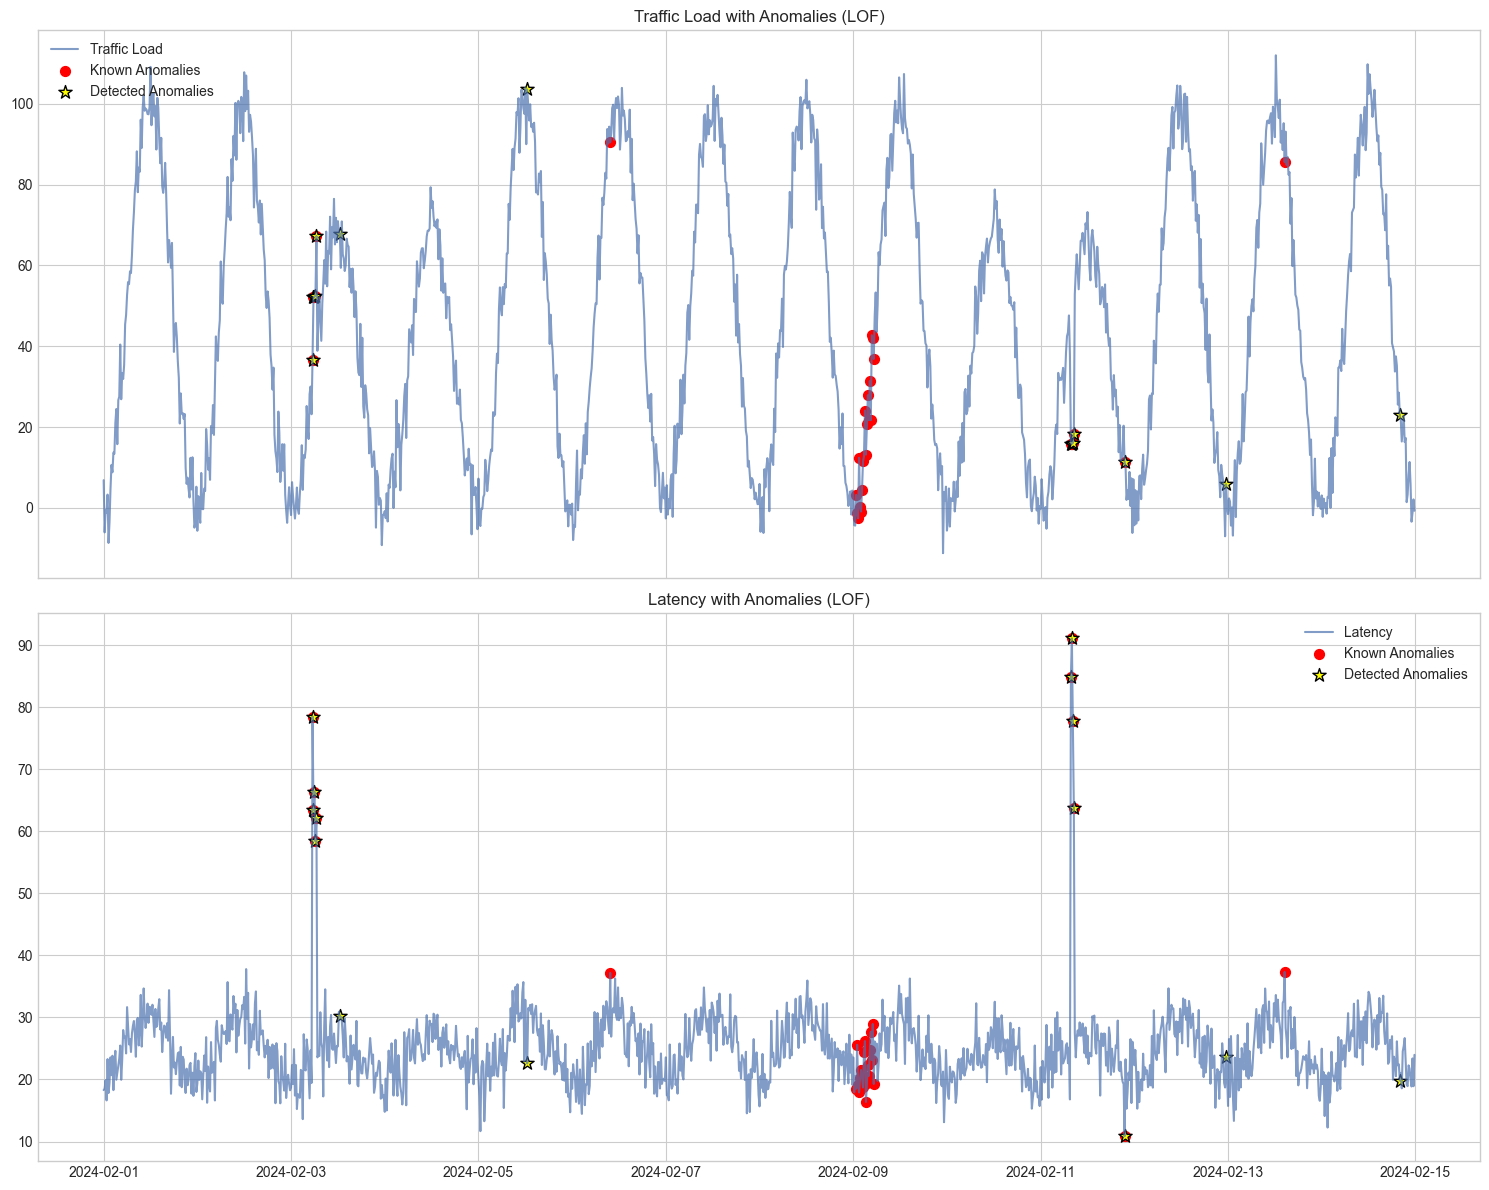

LOF Performance Metrics
True Positives: 10
False Positives: 4
True Negatives: 1309
False Negatives: 21
Precision: 0.71
Recall: 0.32
F1-Score: 0.44


In [32]:
print("\n==== Local Outlier Factor ====")
# Train the Local Outlier Factor model
lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=0.01
)

#Fit and predict
lof_pred = lof.fit_predict(df_scaled)
lof_results = plot_anomaly_results(df, lof_pred, 'LOF')

#### 2.4.DBSCAN


==== DBSCAN ====


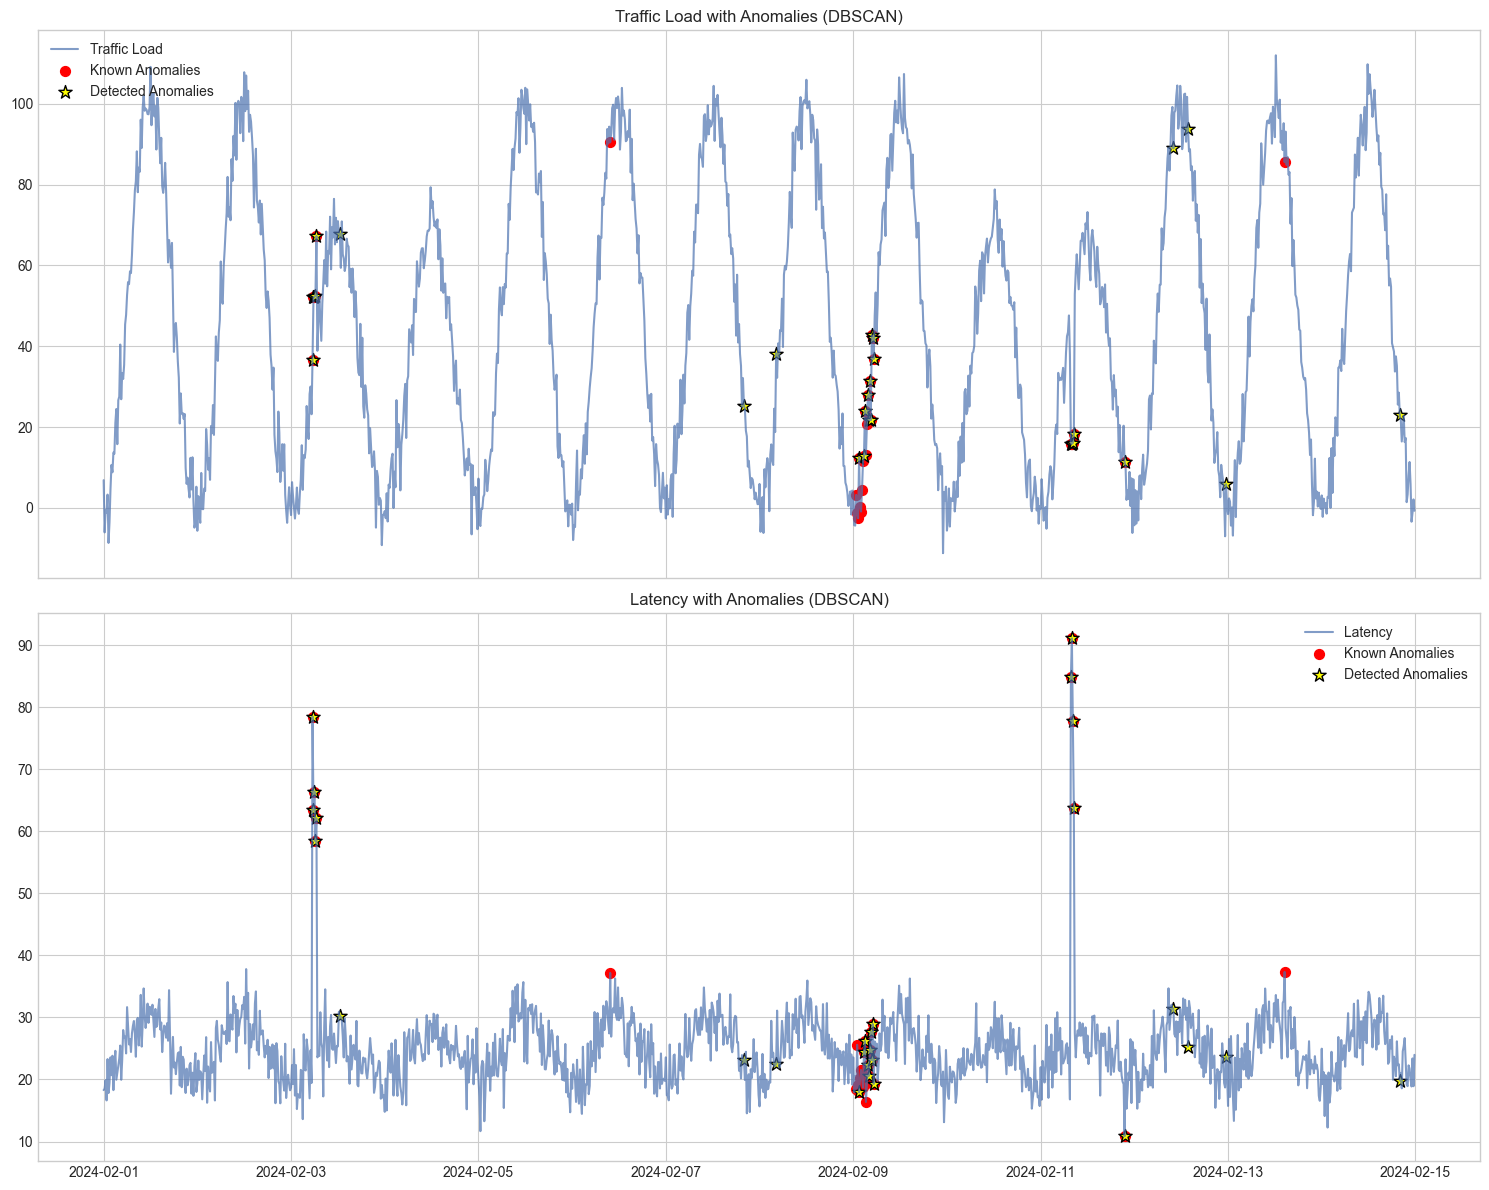

DBSCAN Performance Metrics
True Positives: 20
False Positives: 7
True Negatives: 1306
False Negatives: 11
Precision: 0.74
Recall: 0.65
F1-Score: 0.69


In [33]:
print("\n==== DBSCAN ====")
# Train the DBSCAN model
dbscan = DBSCAN(eps=1.0, min_samples=5)

#Fit and predict
dbscan_labels = dbscan.fit_predict(df_scaled)
#Convert db scan labels to binary anomaly indicators (-1 for anomalies, 1 for normal)
dbscan_pred = np.where(dbscan_labels == -1, -1, 1)
dbscan_results = plot_anomaly_results(df, dbscan_pred, 'DBSCAN')

### 3. Model Comparison


Model Comparison


,precision,recall,f1,true_positives,false_positives
IsolationForest,1.000000,0.451613,0.622222,14.0,0.0
OneClassSVM,0.400000,0.322581,0.357143,10.0,15.0
LOF,0.714286,0.322581,0.444444,10.0,4.0
DBSCAN,0.740741,0.645161,0.689655,20.0,7.0


<Figure size 1200x600 with 0 Axes>

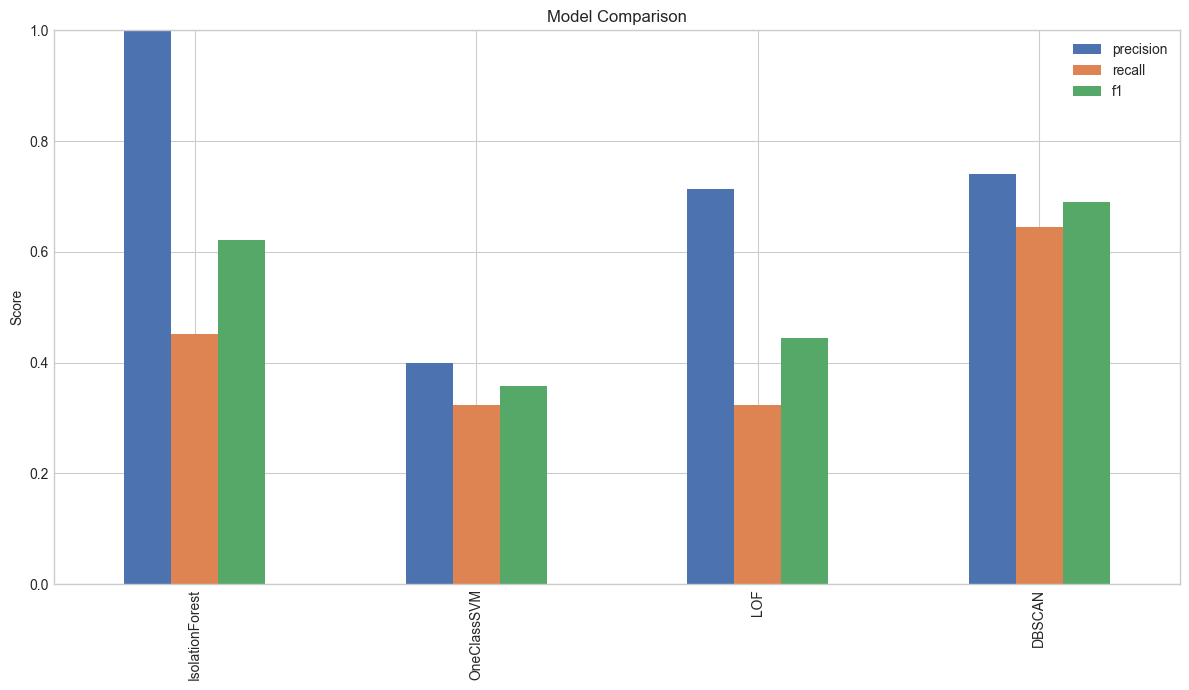

In [35]:
models = ['IsolationForest', 'OneClassSVM', 'LOF', 'DBSCAN']
model_results = {}

#Calculate metrics for each model
for model in models:
    result_col = f'{model}_anomaly'
    
    #Extract prediction from results ( assuming we have them in the previous cells)
    if model == 'IsolationForest':
        predictions = iso_results[result_col]
    elif model == 'OneClassSVM':
        predictions = one_class_svm_results[result_col]
    elif model == 'LOF':
        predictions = lof_results[result_col]
    elif model == 'DBSCAN':
        predictions = dbscan_results[result_col]
    
    #Convert to binary format for sci-kit learn metrics ( 1 for normal, -1 for anomaly)
    y_true = df['known_anomaly'].astype(int)
    y_pred = (predictions == -1).astype(int)
    
    #Caclculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    #Calculate precision, recall and f1-score
    precision = tp / (tp + fp) if tp + fp > 0 else 0
    recall = tp / (tp + fn) if tp + fn > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    
    model_results[model] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'true_positives': tp,
        'false_positives': fp,
    }
    
#Create comparison dataframe
comparison_df = pd.DataFrame(model_results).T
print("\nModel Comparison")
display(comparison_df)

#Plot model comparison
plt.figure(figsize=(12, 6))
comparison_df[['precision','recall', 'f1']].plot(kind='bar')
plt.title('Model Comparison')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('model_comparison.png')
plt.show()

#### 4. Ensemble Approach


==== Ensemble Method ====


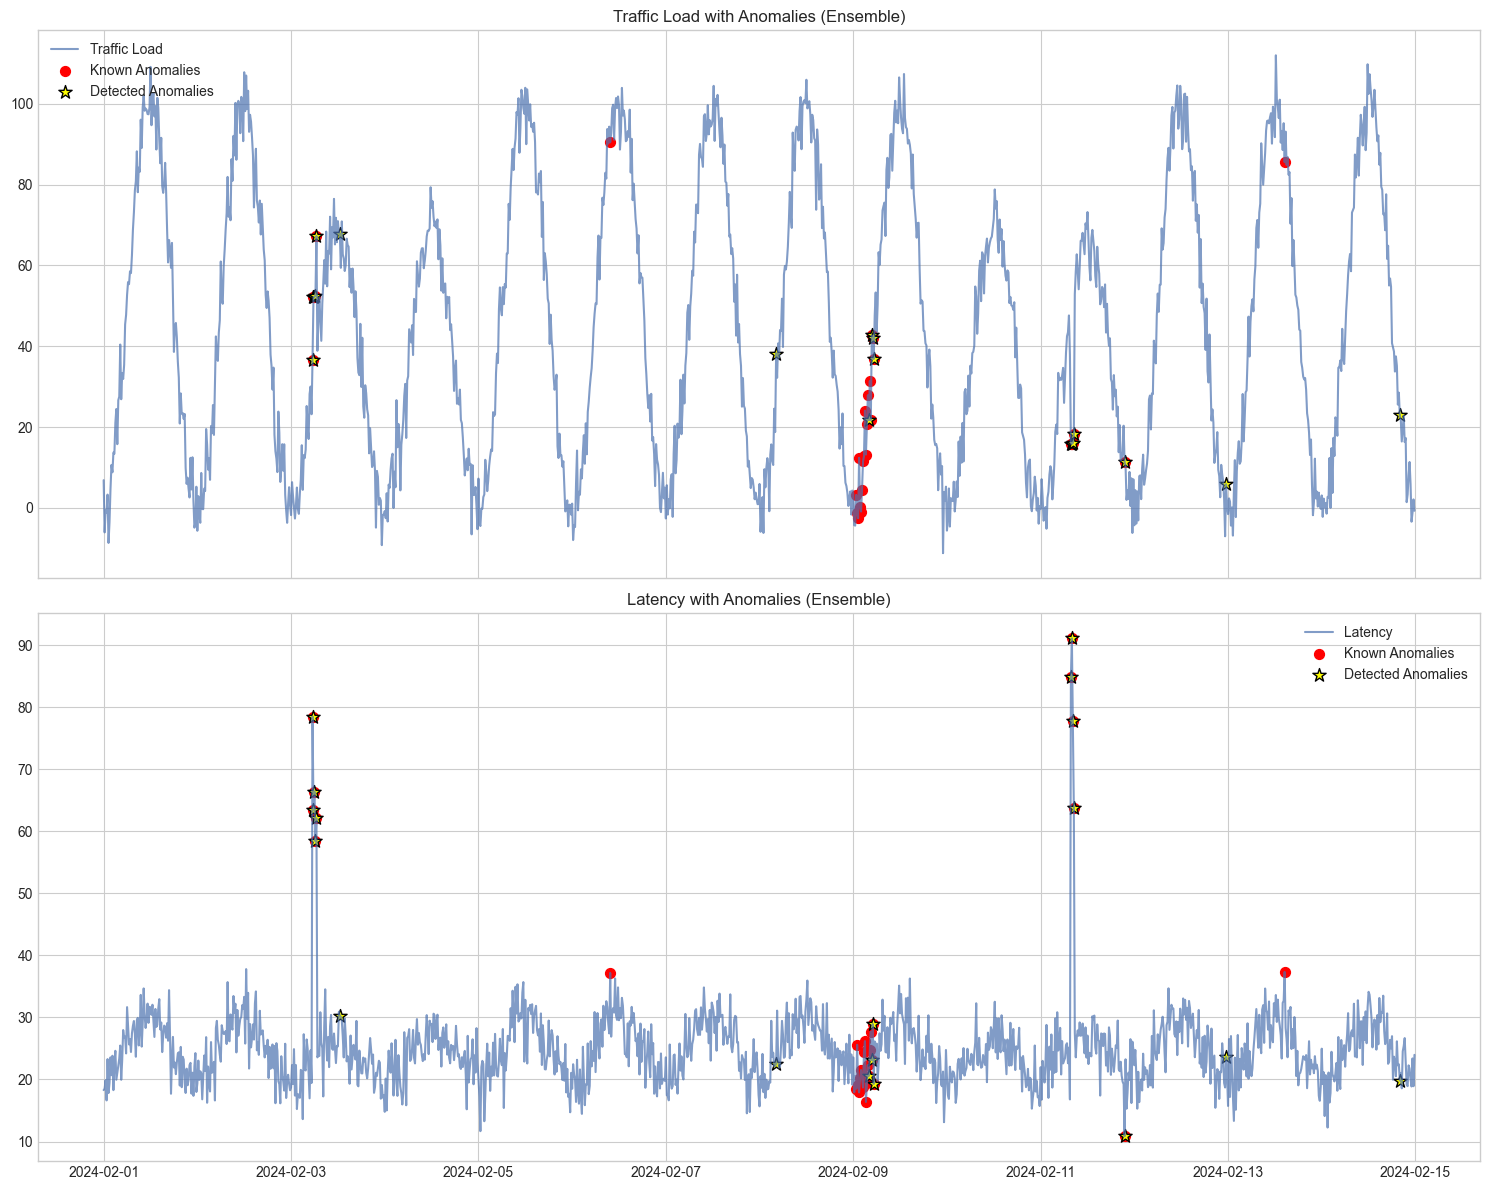

Ensemble Performance Metrics
True Positives: 14
False Positives: 4
True Negatives: 1309
False Negatives: 17
Precision: 0.78
Recall: 0.45
F1-Score: 0.57


In [37]:
print("\n==== Ensemble Method ====")

#Create Ensemble prediction if more than one mode predicts an anomaly
df['ensemble_votes'] = ((iso_results['IsolationForest_anomaly'] == -1).astype(int) +(one_class_svm_results['OneClassSVM_anomaly'] == -1).astype(int) + (lof_results['LOF_anomaly'] == -1).astype(int) + (dbscan_results['DBSCAN_anomaly'] == -1).astype(int))

#Flag as Anomaly if more than 2 models predict an anomaly
df['ensemble_anomaly'] = np.where(df['ensemble_votes'] >= 2, -1, 1)

#Plot ensemble results
ensemble_results = plot_anomaly_results(df, df['ensemble_anomaly'], 'Ensemble')


#### 5. Feature Importance Analysis


========Feature Importance Analysis==========


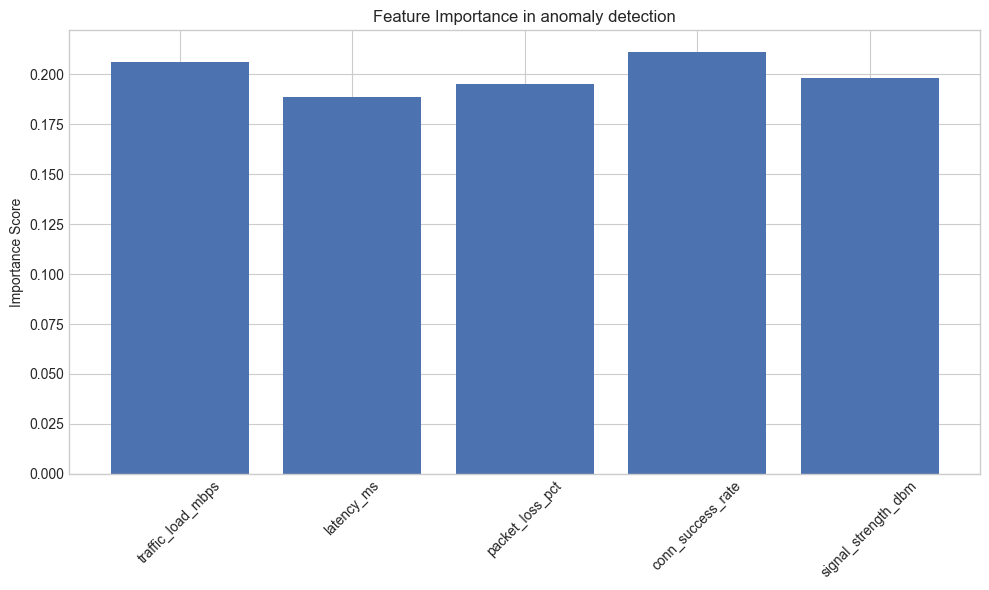

In [39]:
print("\n========Feature Importance Analysis==========")

# Use Isolation Forest feature importances
# Note: This is just an approximation as Isolation Forest doesn't directly provide feature importances
feature_importance = np.zeros(len(kpi_features))
for estimator in iso_forest.estimators_:
    feature_importance += estimator.feature_importances_

feature_importance /= len(iso_forest.estimators_)

#Plot feature importances
plt.figure(figsize=(10,6))
plt.bar(kpi_features, feature_importance)
plt.title("Feature Importance in anomaly detection")
plt.ylabel("Importance Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()



#### 6. Time Based Analysis


======Time Based Analysis======


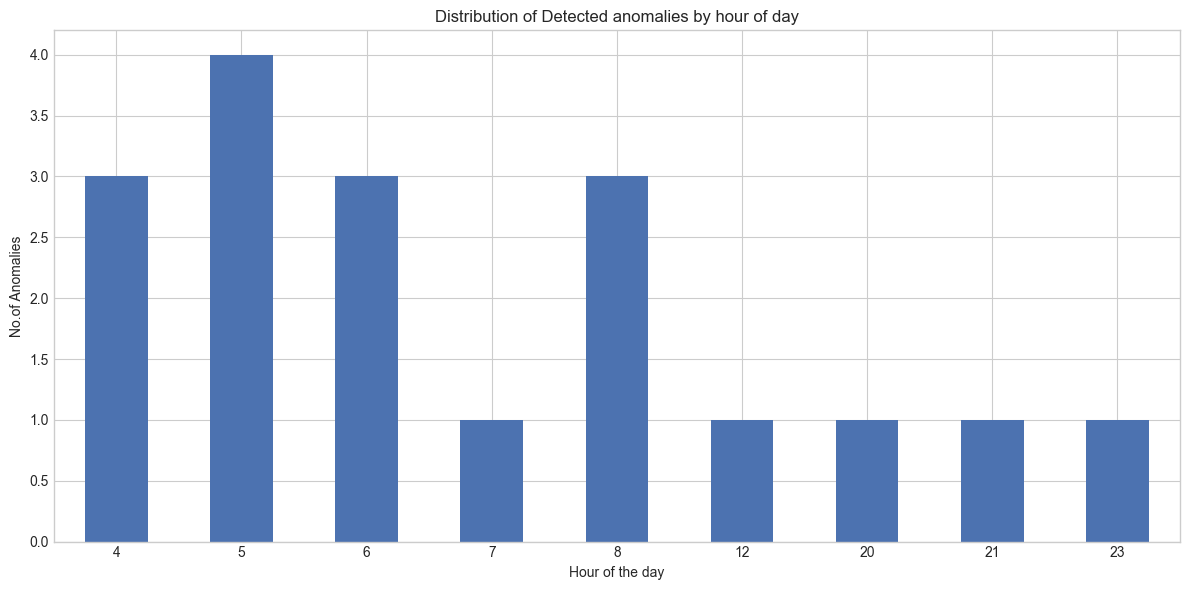


Weekday anomaly rate:0.0073

Weekend anomaly rate:0.0286


In [42]:
print("\n======Time Based Analysis======")

#Group detected anomalies by hour of the day
ensemble_anomalies = df[df['ensemble_anomaly']==-1].copy()
anomalies_by_hour = ensemble_anomalies.groupby(ensemble_anomalies['timestamp'].dt.hour).size()

plt.figure(figsize=(12,6))
anomalies_by_hour.plot(kind="bar")
plt.title("Distribution of Detected anomalies by hour of day")
plt.xlabel('Hour of the day')
plt.ylabel('No.of Anomalies')
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('anomoalies_by_hour.png')
plt.show()

# Group by weekday vs weekend
anomalies_by_day_type = ensemble_anomalies.groupby('is_weekend').size()
normal_by_day_type = df[df['ensemble_anomaly']==1].groupby('is_weekend').size()

#Calculate Anomaly rate
weekday_rate = anomalies_by_day_type.get(0,0) / (anomalies_by_day_type.get(0,0) + normal_by_day_type.get(0,0))
weekend_rate = anomalies_by_day_type.get(1,0) / (anomalies_by_day_type.get(1,0) + normal_by_day_type.get(1,0))

print(f"\nWeekday anomaly rate:{weekday_rate:.4f}")
print(f"\nWeekend anomaly rate:{weekend_rate:.4f}")


#### 7. Save Results and Models

In [43]:
#Save the enhanced dataset with anomaly flags
df.to_csv("telecom_anomaly_data_with_anomalies.csv", index=False)
print(f"Enhanced dataset saved to telecom_anomaly_data_with_anomalies.csv ")

#Save the best model
import joblib
joblib.dump(iso_forest, 'isolation_forest_model.joblib')
print("Isolation Forest model saved to 'islolation_forest_model.joblib'")


Enhanced dataset saved to telecom_anomaly_data_with_anomalies.csv 
Isolation Forest model saved to 'islolation_forest_model.joblib'
